# Feature Creation

### All Imports

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from word_list.basic import politics1, politics2
from word_list.basic import business, preis, huang
from statsmodels.tsa.stattools import adfuller

## Organizing Google trends data

In [2]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_list = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = name
    trends_list.append(ts)

trends = pd.concat(trends_list,1)
trends = trends.fillna(0.0)
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

,BUY AND HOLD,DOW JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial markets,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare earths,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short sell,short selling,short,social,society,stats,stock market,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.0,1.0,14.0,25.0,52.0,4.0,1.0,9.0,5.0,46.0,86.0,18.0,77.0,55.0,31.0,10.0,0.0,3.0,63.0,27.0,4.0,49.0,21.0,3.0,0.0,2.0,0.0,14.0,9.0,52.0,20.0,11.0,52.0,3.0,6.0,5.0,5.0,5.0,1.0,10.0,22.0,1.0,1.0,1.0,1.0,4.0,7.0,4.0,0.0,5.0,1.0,13.0,4.0,4.0,33.0,6.0,0.0,16.0,13.0,1.0,0.0,70.0,1.0,1.0,11.0,22.0,6.0,0.0,32.0,43.0,11.0,27.0,17.0,2.0,0.0,8.0,25.0,0.0,47.0,1.0,34.0,98.0,85.0,12.0,37.0,28.0,4.0,1.0,1.0,7.0,4.0,6.0,16.0,27.0,6.0,35.0,14.0,0.0,3.0,11.0,4.0,25.0,26.0,9.0,3.0,9.0,27.0,45.0,7.0,1.0,6.0,0.0,3.0,26.0,29.0,2.0,100.0,1.0,0.0,1.0,54.0,58.0,28.0,2.0,1.0,35.0,28.0,26.0,6.0,3.0,6.0,3.0,8.0,26.0,3.0,25.0,0.0,3.0,7.0,2.0,4.0,57.0,30.0,4.0,3.0,7.0,7.0,37.0,5.0,6.0,3.0,31.0,7.0,5.0,1.0,1.0,76.0,32.0,1.0,0.0,18.0,19.0,31.0,8.0,3.0,30.0,8.0,3.0,20.0,20.0,66.0,11.0,16.0,23.0,1.0,63.0,7.0,44.0,24.0,0.0,53.0,1.0,1.0,1.0,36.0,60.0,53.0,28.0,0.0,36.0,80.0,80.0
2004-01-02,0.0,2.0,17.0,25.0,90.0,3.0,2.0,5.0,3.0,66.0,76.0,19.0,77.0,49.0,26.0,9.0,1.0,2.0,81.0,25.0,3.0,63.0,18.0,4.0,0.0,2.0,0.0,20.0,11.0,82.0,33.0,11.0,66.0,3.0,8.0,5.0,6.0,5.0,1.0,17.0,32.0,1.0,3.0,1.0,1.0,5.0,4.0,3.0,0.0,3.0,2.0,17.0,4.0,4.0,47.0,11.0,1.0,31.0,11.0,5.0,1.0,52.0,1.0,1.0,5.0,15.0,4.0,2.0,29.0,48.0,16.0,29.0,26.0,3.0,1.0,7.0,18.0,1.0,71.0,2.0,28.0,99.0,95.0,14.0,53.0,35.0,10.0,2.0,1.0,10.0,3.0,6.0,15.0,21.0,9.0,52.0,14.0,1.0,2.0,12.0,7.0,36.0,27.0,13.0,3.0,14.0,27.0,41.0,6.0,2.0,4.0,2.0,3.0,24.0,31.0,4.0,95.0,3.0,0.0,2.0,69.0,63.0,26.0,2.0,1.0,33.0,32.0,30.0,10.0,3.0,2.0,3.0,11.0,36.0,3.0,28.0,0.0,5.0,5.0,1.0,3.0,44.0,25.0,2.0,8.0,8.0,10.0,30.0,6.0,6.0,10.0,43.0,9.0,5.0,3.0,1.0,93.0,59.0,0.0,1.0,14.0,24.0,33.0,4.0,4.0,35.0,10.0,4.0,26.0,18.0,77.0,10.0,11.0,21.0,1.0,59.0,9.0,54.0,16.0,0.0,61.0,2.0,1.0,1.0,41.0,80.0,55.0,32.0,1.0,36.0,94.0,91.0
2004-01-03,0.0,1.0,16.0,22.0,67.0,5.0,1.0,5.0,6.0,51.0,89.0,21.0,89.0,40.0,27.0,9.0,3.0,3.0,70.0,35.0,3.0,49.0,16.0,3.0,0.0,2.0,0.0,13.0,9.0,69.0,23.0,13.0,60.0,5.0,6.0,2.0,6.0,5.0,1.0,16.0,26.0,2.0,2.0,1.0,0.0,2.0,3.0,5.0,1.0,3.0,1.0,12.0,4.0,3.0,34.0,7.0,0.0,14.0,14.0,3.0,1.0,51.0,1.0,1.0,9.0,17.0,8.0,1.0,29.0,41.0,14.0,27.0,19.0,2.0,0.0,6.0,13.0,1.0,53.0,1.0,26.0,93.0,95.0,9.0,44.0,23.0,10.0,1.0,1.0,7.0,3.0,7.0,15.0,26.0,6.0,43.0,13.0,0.0,1.0,13.0,8.0,27.0,32.0,8.0,3.0,11.0,27.0,40.0,8.0,1.0,3.0,2.0,5.0,23.0,28.0,6.0,97.0,2.0,0.0,1.

#### shape = (6121, 192)

### Sanity Check 1

In [3]:
columns = list(trends.columns)

assert [c for c in huang if c not in preis] == []
assert [c for c in preis if c not in columns] == []
assert [c for c in huang if c not in columns] == []
assert [c for c in politics1 if c not in columns] == []
assert [c for c in politics2 if c not in columns] == []
assert [c for c in business if c not in columns] == []

### Selecting Words

In [4]:
selected_words = politics1 + politics2 + business + preis
selected_words = list(set(selected_words))
selected_words.sort()
if trends.notability.max() == 0:
    selected_words.remove("notability")
curme = [c for c in selected_words if c not in preis]
trends = trends[selected_words]
columns = list(trends.columns)

### Sanity Check 2

In [5]:
assert trends.loc[:, (trends != 0).any(axis=0)].shape == trends.shape

### Simple Plot

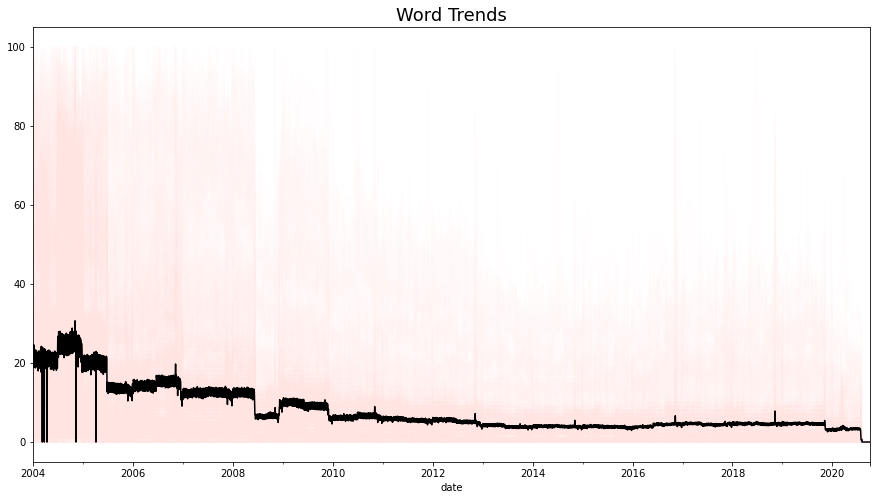

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trends", fontsize=18);

## Creating Features

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$, we define the word feature ${D^{w}}_t$ as the first difference:

\begin{equation}
{D^{w}}_{t} = {S^{w}}_t - {S^{w}}_{t-1}.
\end{equation}

### Sanity Check 3

In [7]:
alpha = 0.01
diff_param = 1
obs = []
for c in tqdm(trends.columns):
    s = trends[c].diff(diff_param).dropna().values
    result_adfuller = adfuller(s)
    p_value = result_adfuller[1]
    obs.append((c, p_value, p_value < alpha))
    
obs = pd.DataFrame(obs, columns=["column","p_value","test"])
assert np.all(obs["test"])

100%|██████████| 182/182 [01:49<00:00,  1.66it/s]


### DataFrame with first differences only

In [8]:
trends = trends.diff(1).dropna()
trends.head(5)

,BUY AND HOLD,DOW JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,...,virginia,voters,votes,war,washington,water,william,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.0,1.0,3.0,0.0,38.0,-1.0,1.0,-4.0,-2.0,20.0,...,8.0,0.0,0.0,5.0,20.0,2.0,4.0,0.0,14.0,11.0
2004-01-03,0.0,-1.0,-1.0,-3.0,-23.0,2.0,-1.0,0.0,3.0,-15.0,...,-6.0,0.0,0.0,10.0,-8.0,-8.0,-3.0,-2.0,-13.0,-16.0
2004-01-04,1.0,0.0,2.0,4.0,-10.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,9.0,-4.0,1.0,5.0,-5.0,6.0,10.0
2004-01-05,-1.0,0.0,3.0,3.0,-7.0,-3.0,0.0,-1.0,-3.0,1.0,...,1.0,1.0,1.0,4.0,-1.0,3.0,5.0,1.0,4.0,-15.0
2004-01-06,0.0,1.0,10.0,1.0,37.0,5.0,0.0,-1.0,1.0,34.0,...,21.0,0.0,-1.0,-12.0,33.0,9.0,2.0,11.0,-7.0,29.0


### Saving

In [9]:
path = os.path.join("data", "gtrends.csv")
trends.to_csv(path)

### Checking correlation

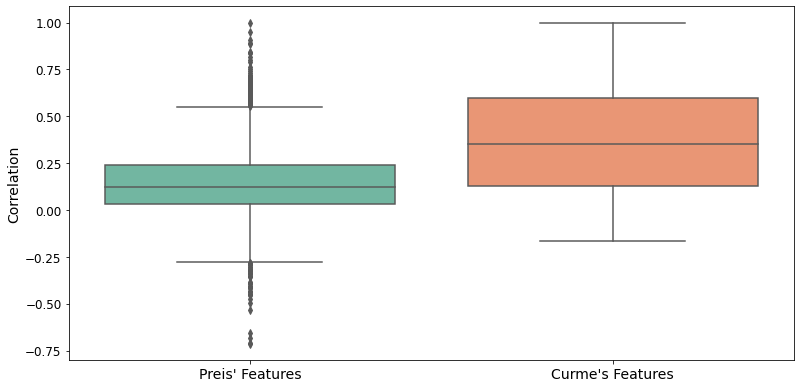

In [22]:
corr_preis = trends[preis].corr().values.flatten()
corr_preis = np.unique(corr_preis)
corr_curme = trends[curme].corr().values.flatten()
corr_curme = np.unique(corr_curme)
corr = trends.corr().values.flatten()
corr = np.unique(corr)
m = np.max([corr_preis.shape[0], corr_curme.shape[0], corr.shape[0]])
corr_preis  = np.append(corr_preis, np.repeat(np.nan, m - corr_preis.shape[0]))
corr_curme  = np.append(corr_curme, np.repeat(np.nan, m - corr_curme.shape[0]))
corr  = np.append(corr, np.repeat(np.nan, m - corr.shape[0]))
corr_df = pd.DataFrame({"Preis' Features":corr_preis, "Curme's Features":corr_curme})

factor = 1.3
fig, ax = plt.subplots(figsize=(10*factor, 5*factor))
sns.boxplot(data=corr_df, orient="v", palette="Set2", ax=ax)
plt.yticks(fontsize=12);
ax.set_ylabel("Correlation", fontsize=14)
plt.xticks(fontsize=14);